In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Step 1: Load the dataset
df_filtered = pd.read_json('/content/train.json')
df_filtered = df_filtered.sample(frac=0.1, random_state=42)

# Step 2: Convert 'created' column to datetime format
df_filtered['created'] = pd.to_datetime(df_filtered['created'])

# Step 3: Extract useful components from the 'created' column
df_filtered['year'] = df_filtered['created'].dt.year
df_filtered['month'] = df_filtered['created'].dt.month
df_filtered['day'] = df_filtered['created'].dt.day
df_filtered['hour'] = df_filtered['created'].dt.hour
df_filtered['minute'] = df_filtered['created'].dt.minute
df_filtered['second'] = df_filtered['created'].dt.second

# Drop the original 'created' column as it's no longer needed
df_filtered.drop(columns=['created'], inplace=True)
df_filtered.drop(columns=['manager_id'], inplace=True)

In [2]:
# Step 4: Process list columns ('features' and 'photos')
# For 'features' column: Count the number of features in the list
df_filtered['features_count'] = df_filtered['features'].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)

# For 'photos' column: Count the number of photos in the list
df_filtered['photos_count'] = df_filtered['photos'].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)

# Drop original 'features' and 'photos' columns
df_filtered.drop(columns=['features', 'photos'], inplace=True)

# Step 5: Handle text columns like 'description' if present
if 'description' in df_filtered.columns:
    # Use CountVectorizer to convert descriptions to numerical values
    vectorizer = CountVectorizer(stop_words='english', max_features=100)  # Limiting to top 100 features for simplicity
    description_matrix = vectorizer.fit_transform(df_filtered['description'])
    description_df = pd.DataFrame(description_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    df_filtered = pd.concat([df_filtered, description_df], axis=1)
    df_filtered.drop(columns=['description'], inplace=True)

In [3]:
# Step 6: One-hot encode categorical columns
categorical_columns = ['building_id', 'display_address', 'street_address']
df_encoded = pd.get_dummies(df_filtered, columns=categorical_columns, drop_first=True)

# Step 7: Label encode the target column (interest_level)
label_encoder = LabelEncoder()
df_encoded['interest_level'] = label_encoder.fit_transform(df_encoded['interest_level'])

# Define the target column (ensure this matches your target column name)
target_column = 'interest_level'

# Step 8: Separate features (X) and target (y)
X = df_encoded.drop(columns=[target_column])
y = df_encoded[target_column]

In [4]:
# Step 9: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [5]:
# Step 10: Train a decision tree classifier
clf = DecisionTreeClassifier(max_depth=2, random_state=5)
clf.fit(X_train, y_train)

# Step 11: Evaluate the model
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

# Optional: Predict on new unseen data
# Example:
# new_data = pd.DataFrame([...])  # Your new data to predict on
# new_data_encoded = pd.get_dummies(new_data, columns=categorical_columns, drop_first=True)
# new_predictions = clf.predict(new_data_encoded)
# new_predictions = label_encoder.inverse_transform(new_predictions)  # Convert to original labels

Accuracy: 0.8473439917483239


**Random Forest**

In [6]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [7]:
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

Accuracy Score: 0.8468282619907168
Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.02      0.03        64
           1       0.71      0.99      0.82       692
           2       0.36      0.02      0.04       232
           3       1.00      1.00      1.00       951

    accuracy                           0.85      1939
   macro avg       0.58      0.51      0.47      1939
weighted avg       0.79      0.85      0.79      1939



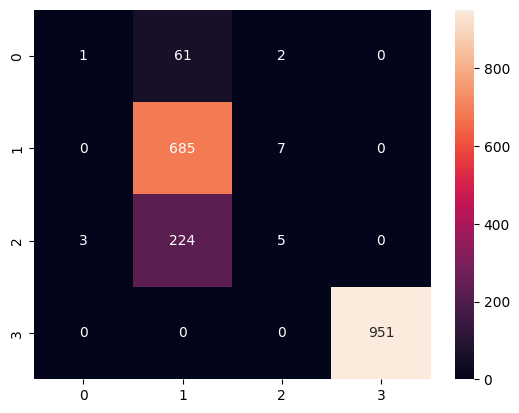

In [8]:
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

**Hyper-parameter Tuning**

Training model 1 with parameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2}
Model 1 Accuracy: 0.8468
Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.02      0.03        64
           1       0.71      0.99      0.82       692
           2       0.36      0.02      0.04       232
           3       1.00      1.00      1.00       951

    accuracy                           0.85      1939
   macro avg       0.58      0.51      0.47      1939
weighted avg       0.79      0.85      0.79      1939



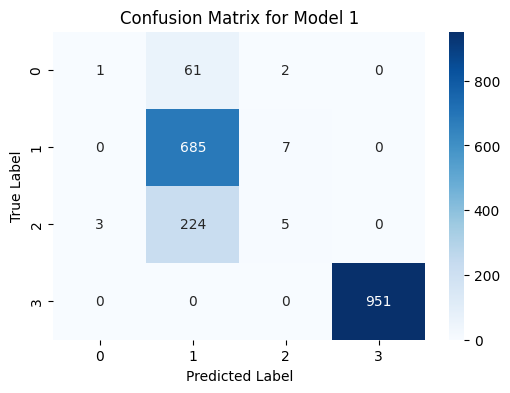

Training model 2 with parameters: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 5}
Model 2 Accuracy: 0.8473
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        64
           1       0.70      1.00      0.82       692
           2       0.00      0.00      0.00       232
           3       1.00      1.00      1.00       951

    accuracy                           0.85      1939
   macro avg       0.43      0.50      0.46      1939
weighted avg       0.74      0.85      0.78      1939



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


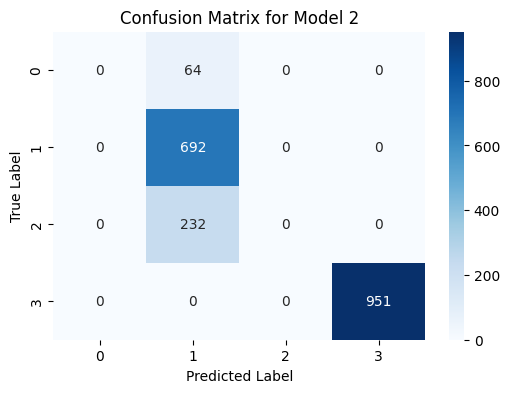

Training model 3 with parameters: {'n_estimators': 300, 'max_depth': 30, 'min_samples_split': 10}
Model 3 Accuracy: 0.8473
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        64
           1       0.70      1.00      0.82       692
           2       0.00      0.00      0.00       232
           3       1.00      1.00      1.00       951

    accuracy                           0.85      1939
   macro avg       0.43      0.50      0.46      1939
weighted avg       0.74      0.85      0.78      1939



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


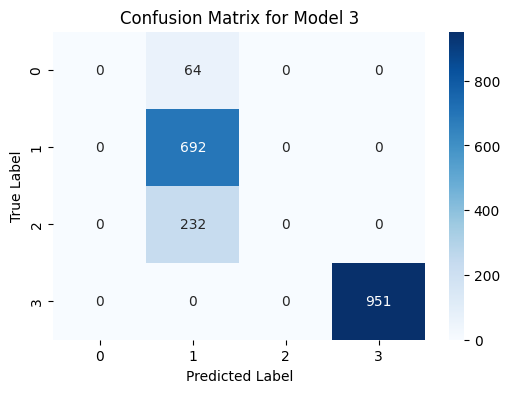


Comparison of Results:
Parameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2}, Accuracy: 0.8468
Parameters: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 5}, Accuracy: 0.8473
Parameters: {'n_estimators': 300, 'max_depth': 30, 'min_samples_split': 10}, Accuracy: 0.8473


In [9]:
# Manually select three sets of hyperparameters
param_sets = [
    {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2},
    {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 5},
    {'n_estimators': 300, 'max_depth': 30, 'min_samples_split': 10},
]

# Store results for comparison
results = []

for i, params in enumerate(param_sets):
    print(f"Training model {i + 1} with parameters: {params}")
    # Train Random Forest with the selected hyperparameters
    rf_model = RandomForestClassifier(**params, random_state=42)
    rf_model.fit(X_train, y_train)

    # Evaluate on the test set
    y_test_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)

    # Store results
    results.append({'params': params, 'accuracy': accuracy})

    # Print accuracy and confusion matrix
    print(f"Model {i + 1} Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_test_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for Model {i + 1}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Compare results
print("\nComparison of Results:")
for result in results:
    print(f"Parameters: {result['params']}, Accuracy: {result['accuracy']:.4f}")


**Cross-Validation**

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Define the first set of hyperparameters
params = {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2}

# Number of folds for cross-validation
cv_folds = 5

print(f"Performing cross-validation with parameters: {params}")
# Initialize Random Forest with the selected hyperparameters
rf_model = RandomForestClassifier(**params, random_state=42)

# Perform cross-validation
scores = cross_val_score(rf_model, X_train, y_train, cv=cv_folds, scoring='accuracy')

# Calculate mean accuracy and standard deviation
mean_score = scores.mean()
std_dev = scores.std()

# Print cross-validation results
print(f"Mean Accuracy: {mean_score:.4f}, Std Dev: {std_dev:.4f}")

Performing cross-validation with parameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2}
Mean Accuracy: 0.8445, Std Dev: 0.0020
